In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from ordpy import ordinal_sequence
import operator
from tqdm import tqdm

In [2]:
def logistic(r,x):
    return r*x*(1-x)

def logistic_orbit(r,n_iter,x_0):
    time_series = []
    x_0 = 0.4
    
    time_series.append(x_0)
    for i in range(n_iter):
        previous = time_series[i]
        new = logistic(r,previous)
        time_series.append(new)
    
    return time_series

In [3]:
def coupled_logistic(r,alpha,x_0,y_0,n_iter,transient):
    x_n = np.zeros(n_iter)
    y_n = np.zeros(n_iter)
    
    x_n[0] = x_0
    y_n[0] = y_0
    
    for i in range(n_iter-1):
        x_n[i+1] = (1 - alpha)*r*x_n[i]*(1 - x_n[i]) + alpha*r*y_n[i]*(1 - y_n[i])
        y_n[i+1] = (1 - alpha)*r*y_n[i]*(1 - y_n[i]) + alpha*r*x_n[i]*(1 - x_n[i])
        
    return x_n[transient:],y_n[transient:]

In [5]:
def co_occur(region1,region2):
    N = len(region1) # Since length of all ordinal sequences are the same 
    
    co_occur_join = []
    for i in range(N):
        #joined = region1[i] + region2[i]
        joined = (region1[i],region2[i])
        co_occur_join.append(joined)
    
    return co_occur_join

def count_frequency(input_list,highest_freq=True):
    '''
    Count frequency of each unique element in input_list
    '''
    freq = {} # Create empty dictionary
    for item in input_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    if highest_freq==True:
        return dict(sorted(freq.items(),key = operator.itemgetter(1),reverse=True))
    else:
        return freq

In [6]:
def block_ordinal_sequence(region_choice,window_length):
    '''
    Generate ordinal sequence with NO OVERLAP
    Inputs:
        1) region_choice = m x N array for an m-dimensional time series, where each time series is of length N
        2) window_length = required window length
    '''  
    region_seq_split = []
    for i in range(len(region_choice)):
        time_series = region_choice[i]
        test = [time_series[window_length*x:window_length*x+window_length] for x in range(len(time_series))]
        
        test1 = []
        for j in range(len(test)):
            compare = test[j]
            if len(compare) < window_length:
                pass
            else:
                test1.append(compare)
        region_seq_split.append(test1)
    
    ordinal_patterns = []
    for i in range(len(region_seq_split)):
        thingo = region_seq_split[i]
        
        pattern_seq = []
        for j in range(len(thingo)):
            component = thingo[j]
            pattern = np.argsort(component)
            #pattern_seq.append(str(pattern))
            pattern_seq.append(str(pattern))
        ordinal_patterns.append(np.asarray(pattern_seq))
    
    return ordinal_patterns

In [11]:
def derived_coupling_strength_no_overlap(window_length,r,alpha_min,alpha_max,alpha_step,total_time,transient):
    alphas = np.arange(alpha_min,alpha_max,alpha_step)
    noise_level = [0.05,0.1,0.2]
    

    x_0 = np.random.uniform(0,1)
    y_0 = np.random.uniform(0,1)
    
    couplings = []
    couplings1 = []
    couplings2 = []
    couplings3 = []
    for j in tqdm(range(len(alphas))):
        alpha = alphas[j]
        
        x,y = coupled_logistic(r,alpha,x_0,y_0,total_time,transient)
        noise_x1 = x + np.random.normal(0,noise_level[0],total_time-transient)
        noise_x2 = x + np.random.normal(0,noise_level[1],total_time-transient)
        noise_x3 = x + np.random.normal(0,noise_level[2],total_time-transient)
        
        noise_y1 = y + np.random.normal(0,noise_level[0],total_time-transient)
        noise_y2 = y + np.random.normal(0,noise_level[1],total_time-transient)
        noise_y3 = y + np.random.normal(0,noise_level[2],total_time-transient)

        block_log = np.asarray((x,y))
        block_log1 = np.asarray((noise_x1,noise_y1))
        block_log2 = np.asarray((noise_x2,noise_y2))
        block_log3 = np.asarray((noise_x3,noise_y3))
        
        ord_seq_x,ord_seq_y = block_ordinal_sequence(block_log,window_length)
        ord_seq_x1,ord_seq_y1 = block_ordinal_sequence(block_log1,window_length)
        ord_seq_x2,ord_seq_y2 = block_ordinal_sequence(block_log2,window_length)
        ord_seq_x3,ord_seq_y3 = block_ordinal_sequence(block_log3,window_length)
        
        freq_dict = count_frequency(co_occur(ord_seq_x,ord_seq_y))
        coupling = len(freq_dict)
        couplings.append(coupling/(math.factorial(window_length))**2)
        
        freq_dict1 = count_frequency(co_occur(ord_seq_x1,ord_seq_y1))
        coupling1 = len(freq_dict1)
        couplings1.append(coupling1/(math.factorial(window_length))**2)
        
        freq_dict2 = count_frequency(co_occur(ord_seq_x2,ord_seq_y2))
        coupling2 = len(freq_dict2)
        couplings2.append(coupling2/(math.factorial(window_length))**2)
        
        freq_dict3 = count_frequency(co_occur(ord_seq_x3,ord_seq_y3))
        coupling3 = len(freq_dict3)
        couplings3.append(coupling3/(math.factorial(window_length))**2)
        
    return alphas,couplings,couplings1,couplings2,couplings3

In [13]:
def cross_correlation_plot(r,alpha_min,alpha_max,alpha_step,total_time,transient):
    import statsmodels.api as sm
    
    alphas = np.arange(alpha_min,alpha_max,alpha_step)
    noise_level = [0.05,0.1,0.2]
    
    x_0 = np.random.uniform(0,1)
    y_0 = np.random.uniform(0,1)
    
    cross_correlation = []
    cross_correlation_1 = []
    cross_correlation_2 = []
    cross_correlation_3 = []
    
    for i in tqdm(range(len(alphas))):
        alpha = alphas[i]
        x,y = coupled_logistic(4,alpha,x_0,y_0,total_time,transient)
        
        noise_x1 = x + np.random.normal(0,noise_level[0],total_time-transient)
        noise_x2 = x + np.random.normal(0,noise_level[1],total_time-transient)
        noise_x3 = x + np.random.normal(0,noise_level[2],total_time-transient)
        
        noise_y1 = y + np.random.normal(0,noise_level[0],total_time-transient)
        noise_y2 = y + np.random.normal(0,noise_level[1],total_time-transient)
        noise_y3 = y + np.random.normal(0,noise_level[2],total_time-transient)
        
        cross = sm.tsa.stattools.ccf(x,y,adjusted=False)
        max_ting = max(cross)
        cross_correlation.append(max_ting)
        
        cross_1 = sm.tsa.stattools.ccf(noise_x1,noise_y1,adjusted=False)
        max_ting_1 = max(cross_1)
        cross_correlation_1.append(max_ting_1)
        
        cross_2 = sm.tsa.stattools.ccf(noise_x2,noise_y2,adjusted=False)
        max_ting_2 = max(cross_2)
        cross_correlation_2.append(max_ting_2)
        
        cross_3 = sm.tsa.stattools.ccf(noise_x3,noise_y3,adjusted=False)
        max_ting_3 = max(cross_3)
        cross_correlation_3.append(max_ting_3)
        
    return alphas,cross_correlation, cross_correlation_1, cross_correlation_2, cross_correlation_3

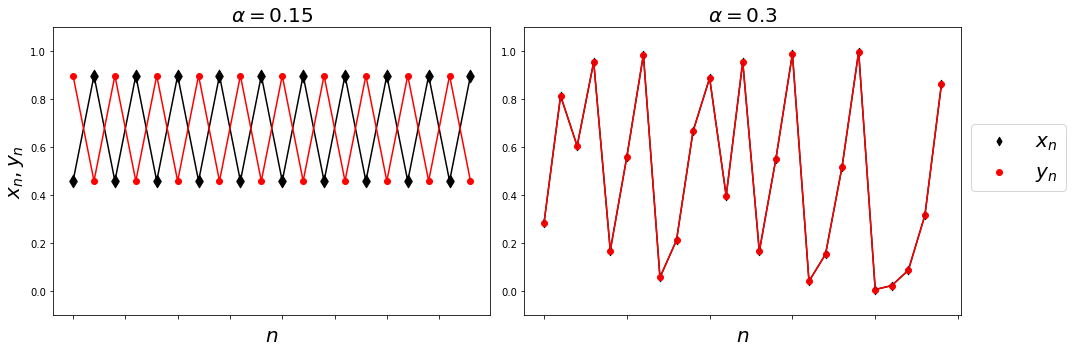

In [14]:
fontsize=20

x,y = coupled_logistic(4,0.15,0.1,0.15,10000,2000)
diff_xy = x+y
opp_diff_xy = x-y
x1,y1 = coupled_logistic(4,0.3,0.1,0.15,10000,2000)
diff_x1y1 = x1-y1
opp_diff_x1y1 = x1+y1

#fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15, 8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x[0:20],c='k')
ax1.scatter([i for i in range(len(x[0:20]))],x[0:20],marker='d',s=80,c='k')
ax1.plot(y[0:20],c='red')
ax1.scatter([i for i in range(len(y[0:20]))],y[0:20],marker='o',c='red')
ax1.set_xticklabels([])
ax1.set_title(r'$\alpha=0.15$',fontsize=fontsize)
ax1.set_ylabel(r'$x_n,y_n$',fontsize=fontsize)
ax1.set_ylim(-0.1,1.1)
ax1.set_xlabel(r'$n$',fontsize=fontsize)
      
ax2.plot(x1[0:25],c='k')
ax2.scatter([i for i in range(len(x1[0:25]))],x1[0:25],marker='d',c='k',label=r'$x_{n}$')
ax2.plot(y1[0:25],c='red')
ax2.scatter([i for i in range(len(y1[0:25]))],y1[0:25],marker='o',c='red',label=r'$y_{n}$')
ax2.set_xticklabels([])
ax2.set_title(r'$\alpha=0.3$',fontsize=fontsize)
ax2.set_ylim(-0.1,1.1)
ax2.set_xlabel(r'$n$',fontsize=fontsize)
ax2.legend(bbox_to_anchor=[1.0,0.7],fontsize=fontsize)

fig.tight_layout()

In [15]:
alphas,a,b,c,d = cross_correlation_plot(4,0,0.5,0.005,10000,2000)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.14it/s]


In [17]:
window_length = 5
r = 4
alpha_min = 0
alpha_max = 0.5
alpha_step = 0.005
total_time = 100000
transient = 20000

In [18]:
alphas,test1,test2,test3,test4 = derived_coupling_strength_no_overlap(window_length,r,alpha_min,alpha_max,alpha_step,total_time,transient)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:24<00:00,  9.24s/it]


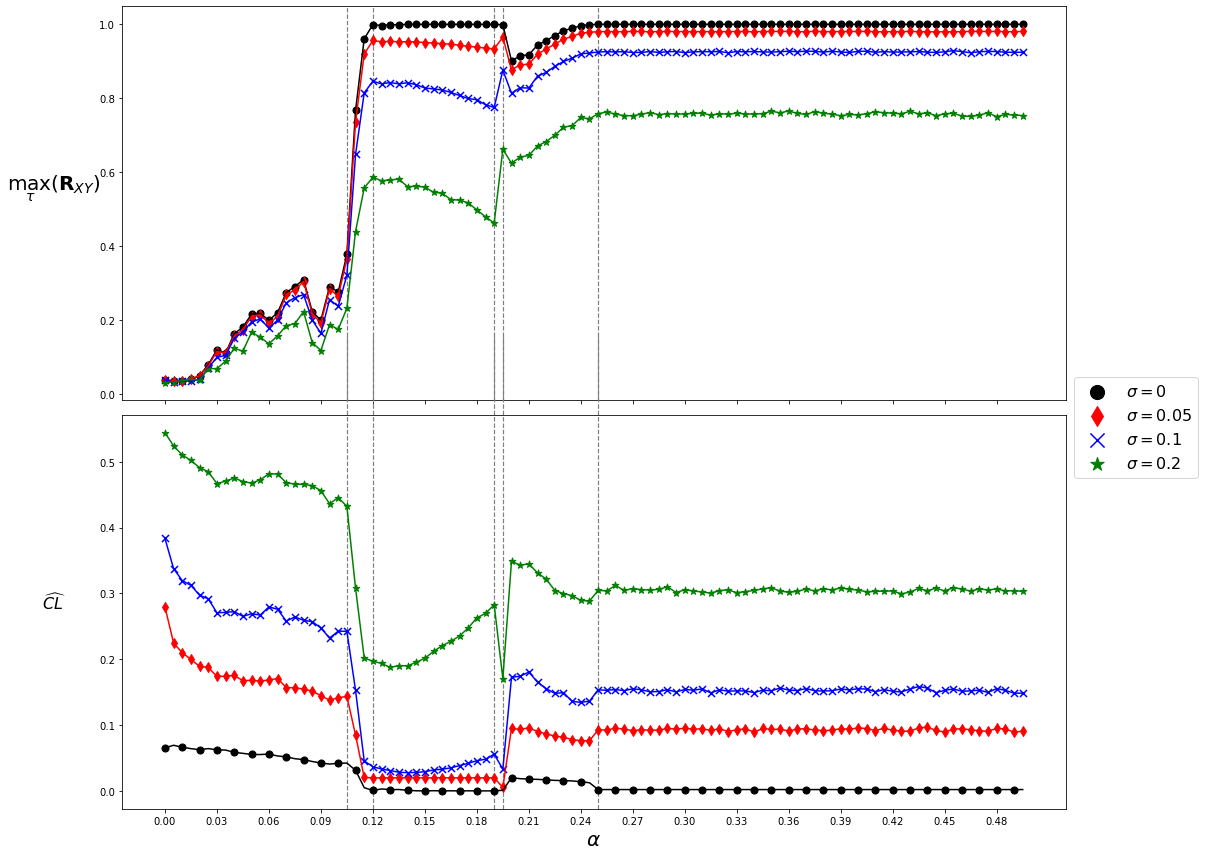

In [27]:
marker_size = 50

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12),sharex=True)

ax1.plot(alphas,a,c='k')
ax1.plot(alphas,b,c='red')
ax1.plot(alphas,c,c='blue')
ax1.plot(alphas,d,c='green')

ax1.scatter(alphas,a,c='k',s=marker_size)
ax1.scatter(alphas,b,marker='d',c='red',s=marker_size)
ax1.scatter(alphas,c,marker='x',c='blue',s=marker_size)
ax1.scatter(alphas,d,marker='*',c='green',s=marker_size)

ax1.set_ylabel(r'$\max_{\tau}{(\mathbf{R}_{XY})}$',fontsize=20,rotation=0,labelpad=45)

ax2.plot(alphas,test1,c='k')
ax2.plot(alphas,test2,c='red')
ax2.plot(alphas,test3,c='blue')
ax2.plot(alphas,test4,c='green')

ax2.scatter(alphas[::2],test1[::2],marker='o',label=r'$\sigma=0$',c='k',s=marker_size)
ax2.scatter(alphas,test2,marker='d',label=r'$\sigma=0.05$',c='red',s=marker_size)
ax2.scatter(alphas,test3,marker='x',label=r'$\sigma=0.1$',c='blue',s=marker_size)
ax2.scatter(alphas,test4,marker='*',label=r'$\sigma=0.2$',c='green',s=marker_size)

ax2.set_ylabel(r'$\widehat{CL}$', fontsize=16,rotation=0,labelpad=45)
ax2.set_xlabel(r'$\alpha$', fontsize=20)
ax2.set_xticks(alphas[::6])

fig.legend(bbox_to_anchor=[1.12,0.5],loc='center right',fontsize=16,markerscale=2)

x_windows = [0.105,0.12,0.19,0.195,0.25]
for i in range(len(x_windows)):
    ax1.axvline(x=x_windows[i],linestyle='--',ymin=0,ymax=1,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax2.axvline(x=x_windows[i],linestyle='--',ymax=1.2,c="grey",linewidth=1.2,zorder=0, clip_on=False)

fig.tight_layout()
#plt.savefig('coupled_logistic_noise.png')